In [1]:
import uproot3
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
#from functions import *
from numpy.linalg import solve
from numpy.core.umath_tests import inner1d
%matplotlib inline
plt.style.use('ggplot')

/home/hep/kj3417/anaconda2/envs/py3/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/hep/kj3417/anaconda2/envs/py3/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(
<ipython-input-1-d6520292ed83>:13: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def root_to_df2(fname,drop_na = False):
    file = uproot3.open('{}'.format(fname))
    decay_tuple = file['DecayTuple/DecayTuple']
    col_names = decay_tuple.keys()
    columns = [col.decode("utf-8") for col in col_names]
    # df = pd.DataFrame(decay_tuple.arrays(columns, flatten=None))
    # df.columns = columns
    #df = decay_tuple.pandas.df(columns, flatten=True)
    Bs = decay_tuple.pandas.df("Bs*", flatten=True)
    phi = decay_tuple.pandas.df("phi3*", flatten=True)
    dist = decay_tuple.pandas.df("DOCA*", flatten=True)
    ip = decay_tuple.pandas.df("IP*", flatten=True)
    fd = decay_tuple.pandas.df("FD*", flatten=True)
    vfit = decay_tuple.pandas.df("VFIT*", flatten=True)
    muminus = decay_tuple.pandas.df("muminus*", flatten=True)
    muplus = decay_tuple.pandas.df("muplus*", flatten=True)
    tauminus = decay_tuple.pandas.df("tauminus*", flatten=True)
    tauplus = decay_tuple.pandas.df("tauplus*", flatten=True)
    Kminus = decay_tuple.pandas.df("Kminus*", flatten=True)
    Kplus = decay_tuple.pandas.df("Kplus*", flatten=True)
    # dfs = [Bs, phi, dist, mu, Kplus, Kminus]
    df = Bs.join(phi, how="outer").join(dist, how="outer").join(ip, how="outer").join(vfit, how="outer").join(fd, how="outer").join(muplus, how="outer").join(muminus, how="outer").join(tauplus, how="outer").join(tauminus, how="outer").join(Kminus, how="outer").join(Kplus, how="outer")
    if drop_na:
        df.dropna(inplace=True)
    return df

In [3]:
def root_to_df(fname,drop_na = False):
    file = uproot3.open('{}'.format(fname))
    decay_tuple = file['DecayTree']
    col_names = decay_tuple.keys()
    columns = [col.decode("utf-8") for col in col_names]
    # df = pd.DataFrame(decay_tuple.arrays(columns, flatten=None))
    # df.columns = columns
    #df = decay_tuple.pandas.df(columns, flatten=True)
    Bs = decay_tuple.pandas.df("Bs*", flatten=True)
    phi = decay_tuple.pandas.df("phi*", flatten=True)
    muminus = decay_tuple.pandas.df("mu_minus*", flatten=True)
    muplus = decay_tuple.pandas.df("mu_plus*", flatten=True)
    tauminus = decay_tuple.pandas.df("tauminus*", flatten=True)
    tauplus = decay_tuple.pandas.df("tauplus*", flatten=True)
    Kminus = decay_tuple.pandas.df("K_minus*", flatten=True)
    Kplus = decay_tuple.pandas.df("K_plus*", flatten=True)
    # dfs = [Bs, phi, dist, mu, Kplus, Kminus]
    df = Bs.join(phi, how="outer").join(muplus, how="outer").join(muminus, how="outer").join(tauplus, how="outer").join(tauminus, how="outer").join(Kminus, how="outer").join(Kplus, how="outer")
    if drop_na:
        df.dropna(inplace=True)
    return df

In [4]:
df = root_to_df2('~/code/kunal/Bender.root', drop_na=True)

In [5]:
df2 = root_to_df('~/Bs2KKmumu/Bs2KKmumu_2017_MagUp.root', drop_na=True)

In [6]:
bs_point = df[['phi3_VX','phi3_VY','phi3_VZ']].to_numpy() #on Bs LOF
mu_plus_point = df[['muplus_RefPoint_X','muplus_RefPoint_Y','muplus_RefPoint_Z']].to_numpy() #on mu + LOF
mu_minus_point = df[['muminus_RefPoint_X','muminus_RefPoint_Y','muminus_RefPoint_Z']].to_numpy() #on mu - LOF

bs_dir = df[['phi3_PX', 'phi3_PY','phi3_PZ']].to_numpy()
mu_plus_dir = df[['muplus_PX','muplus_PY','muplus_PZ']].to_numpy()
mu_minus_dir = df[['muminus_PX','muminus_PY','muminus_PZ']].to_numpy()

n_plus = np.cross(bs_dir,mu_plus_dir)
n_plus = n_plus/np.linalg.norm(n_plus, axis = 1, keepdims = True)
n_minus = np.cross(bs_dir,mu_minus_dir)
n_minus = n_minus/np.linalg.norm(n_minus, axis = 1, keepdims = True)

DOCA_plus = np.abs(((mu_plus_point - bs_point)*n_plus).sum(1))
DOCA_minus = np.abs(((mu_minus_point - bs_point)*n_minus).sum(1))

df['DOCA_analytic_plus'] = DOCA_plus
df['DOCA_analytic_minus'] = DOCA_minus

# adding coords of the closest approach point

coords_plus=np.zeros([len(mu_plus_point[:,0]),3])

for i in range(len(mu_plus_point[:,0])):

    rhs=+mu_plus_point[i,:]-bs_point[i,:]
    lhs=np.array([bs_dir[i,:], -mu_plus_dir[i,:], n_plus[i,:]]).T
    X=solve(lhs,rhs)

    coords_plus[i,:]=bs_point[i,:]+X[0]*bs_dir[i,:] # point on Bs LoF where we have the CDA. Basically the reconstructed decay vertex of the tau

df['tauplus_closest_x'] = coords_plus[:,0]
df['tauplus_closest_y'] = coords_plus[:,1]
df['tauplus_closest_z'] = coords_plus[:,2]


tauplus_closest_vars = ['tauplus_closest_x', 'tauplus_closest_y', 'tauplus_closest_z']


coords_minus=np.zeros([len(mu_minus_point[:,0]),3])

for i in range(len(mu_minus_point[:,0])):

    rhs=+mu_minus_point[i,:]-bs_point[i,:]
    lhs=np.array([bs_dir[i,:],-mu_minus_dir[i,:],n_minus[i,:]]).T
    X=solve(lhs,rhs)

    coords_minus[i,:]=bs_point[i,:]+X[0]*bs_dir[i,:] # point on Bs LoF where we have the CDA. Basically the reconstructed decay vertex of the tau

df['tauminus_closest_x'] = coords_minus[:,0]
df['tauminus_closest_y'] = coords_minus[:,1]
df['tauminus_closest_z'] = coords_minus[:,2]


tauminus_closest_vars = ['tauminus_closest_x', 'tauminus_closest_y', 'tauminus_closest_z']


##########
# calculate doca point on the muon line of flight
##########

coordsnew_plus=np.zeros([len(mu_plus_point[:,0]),3])

for i in range(len(mu_plus_point[:,0])):

    rhs=+mu_plus_point[i,:]-bs_point[i,:]
    lhs=np.array([+mu_plus_dir[i,:], -bs_dir[i,:], n_plus[i,:]]).T
    X=solve(lhs,rhs)

    coordsnew_plus[i,:]=mu_plus_point[i,:]-X[0]*mu_plus_dir[i,:] # point on Bs LoF where we have the CDA. Basically the reconstructed decay vertex of the tau

df['muplus_closest_x'] = coordsnew_plus[:,0]
df['muplus_closest_y'] = coordsnew_plus[:,1]
df['muplus_closest_z'] = coordsnew_plus[:,2]


muplus_closest_vars = ['muplus_closest_x', 'muplus_closest_y', 'muplus_closest_z']


coordsnew_minus=np.zeros([len(mu_minus_point[:,0]),3])

for i in range(len(mu_minus_point[:,0])):

    rhs=+mu_minus_point[i,:]-bs_point[i,:]
    lhs=np.array([+mu_minus_dir[i,:],-bs_dir[i,:],n_minus[i,:]]).T
    X=solve(lhs,rhs)

    coordsnew_minus[i,:]=mu_minus_point[i,:]-X[0]*mu_minus_dir[i,:] # point on Bs LoF where we have the CDA. Basically the reconstructed decay vertex of the tau

df['muminus_closest_x'] = coordsnew_minus[:,0]
df['muminus_closest_y'] = coordsnew_minus[:,1]
df['muminus_closest_z'] = coordsnew_minus[:,2]


muminus_closest_vars = ['muminus_closest_x', 'muminus_closest_y', 'muminus_closest_z']

In [7]:
df[['phi3_TRUE_OVX','phi3_VX', 'Bs_TRUE_VX', 'Bs_VX', 'phi3_PX', 'Bs_PX', 'phi3_TRUE_PX', 'Bs_TRUE_PX']]


,,phi3_TRUE_OVX,phi3_VX,Bs_TRUE_VX,Bs_VX,phi3_PX,Bs_PX,phi3_TRUE_PX,Bs_TRUE_PX
entry,subentry,,,,,,,,
0,0,0.1504,0.859455,0.1504,-0.272051,-4283.616211,-6748.805176,-4270.29,-12038.06
1,0,-0.0135,-0.242190,-0.0135,-0.206118,-1617.753662,-9646.647461,-1610.39,-12038.06
2,0,-0.5663,2.797000,-0.5663,-0.596074,-2168.088135,-5456.062988,-4079.34,-12038.06
3,0,0.5147,0.564435,0.5147,0.406787,-4347.433594,-8690.639648,-4346.59,-12038.06
4,0,0.8402,0.856744,0.8402,0.878515,-3734.453369,-7806.031250,-3735.52,-12038.06
...,...,...,...,...,...,...,...,...,...
18161,0,1.2456,0.829001,1.2456,1.236536,1984.405884,2255.141602,2137.56,3599.37
18162,0,1.0852,1.359831,1.0852,1.162450,664.958557,1666.985107,670.68,3599.37
18163,0,1.6012,1.583231,1.6012,1.603006,1233.384033,2110.563721,1227.58,3599.37


In [8]:
bs_point_1 = df2[['Bs_OWNPV_X', 'Bs_OWNPV_Y', 'Bs_OWNPV_Z']].to_numpy() #on Bs LOF
bs_point_2 = df2[['Bs_ENDVERTEX_X', 'Bs_ENDVERTEX_Y', 'Bs_ENDVERTEX_Z']].to_numpy() #on Bs LOF
mu_plus_point = df2[['mu_plus_REFPX', 'mu_plus_REFPY', 'mu_plus_REFPZ']].to_numpy() #on mu + LOF
#mu_plus_point = df[['mu_plus_OWNPV_X','mu_plus_OWNPV_Y','mu_plus_OWNPV_Z']].applymap(lambda x: x[0]).to_numpy() #on mu + LOF
mu_minus_point = df2[['mu_minus_REFPX', 'mu_minus_REFPY', 'mu_minus_REFPZ']].to_numpy() #on mu - LOF
#mu_minus_point = df[['mu_minus_OWNPV_X','mu_minus_OWNPV_Y','mu_minus_OWNPV_Z']].applymap(lambda x: x[0]).to_numpy() #on mu - LOF

bs_dir = bs_point_1 - bs_point_2
mu_plus_dir = df2[['mu_plus_AtVtx_PX', 'mu_plus_AtVtx_PY', 'mu_plus_AtVtx_PZ']].to_numpy()
mu_minus_dir = df2[['mu_minus_AtVtx_PX', 'mu_minus_AtVtx_PY', 'mu_minus_AtVtx_PZ']].to_numpy()

n_plus = np.cross(bs_dir,mu_plus_dir)
n_plus = n_plus/np.linalg.norm(n_plus, axis = 1, keepdims = True)
n_minus = np.cross(bs_dir,mu_minus_dir)
n_minus = n_minus/np.linalg.norm(n_minus, axis = 1, keepdims = True)

DOCA_plus = np.abs(((mu_plus_point - bs_point_1)*n_plus).sum(1))
DOCA_minus = np.abs(((mu_minus_point - bs_point_1)*n_minus).sum(1))

df2['DOCA_analytic_plus'] = DOCA_plus
df2['DOCA_analytic_minus'] = DOCA_minus


In [9]:
df['DOCA_mu_plus_err'] = df['DOCA_mu_plus']/np.sqrt(df['DOCA_chi2_mu_plus'])
df['DOCA_mu_minus_err'] = df['DOCA_mu_minus']/np.sqrt(df['DOCA_chi2_mu_minus'])

In [10]:
doca_cols = ['DOCA_mu_plus','DOCA_mu_minus', 'DOCA_analytic_plus', 'DOCA_analytic_minus']
df[doca_cols].describe()

,DOCA_mu_plus,DOCA_mu_minus,DOCA_analytic_plus,DOCA_analytic_minus
count,18032.000000,18032.000000,18032.000000,18032.000000
mean,0.243561,0.269201,0.248522,0.272987
std,1.700058,1.875291,1.584491,1.843615
min,0.000001,0.000004,0.000008,0.000005
25%,0.019126,0.019323,0.019254,0.019489
50%,0.044723,0.045228,0.045182,0.045705
75%,0.097320,0.096131,0.099164,0.098532
max,73.881259,88.652037,64.744949,88.639168


In [11]:
df['Bs_VX']

entry  subentry
0      0          -0.272051
1      0          -0.206118
2      0          -0.596074
3      0           0.406787
4      0           0.878515
                     ...   
18161  0           1.236536
18162  0           1.162450
18163  0           1.603006
18164  0           0.999902
18165  0           1.147017
Name: Bs_VX, Length: 18032, dtype: float32

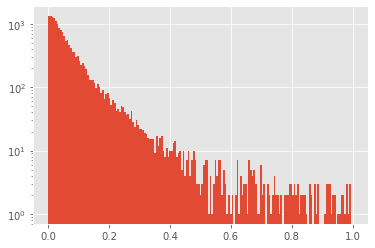

In [12]:
plt.figure()
df['DOCA_mu_plus'].hist(bins = 'auto', range = (0,1))
plt.yscale('log')
plt.show()

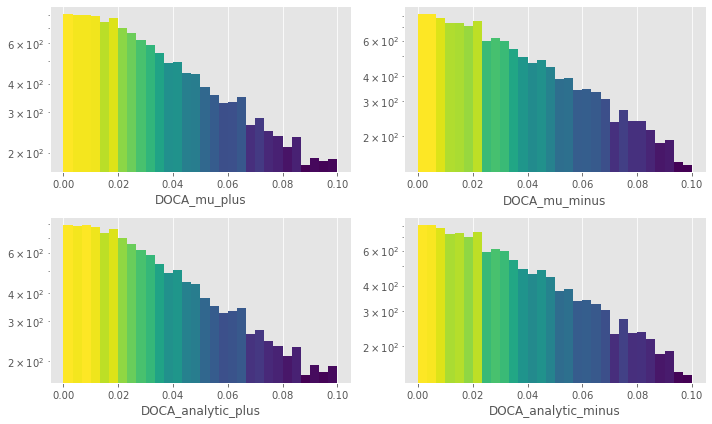

In [13]:
fig, ax = plt.subplots(nrows = 2 , ncols = 2, figsize = (10,6))
i = 0
for row in ax:
    for col in row:
        N, bins, patches = col.hist(df[df["DOCA_mu_plus"] < 1][doca_cols[i]], bins = 'auto', range = (0,0.1))
        fracs = N / N.max()
        norm = colors.Normalize(fracs.min(), fracs.max())
        for thisfrac, thispatch in zip(fracs, patches):
            color = plt.cm.viridis(norm(thisfrac))
            thispatch.set_facecolor(color)
        col.set_yscale('log')
        col.set_xlabel(doca_cols[i])
        i+=1
plt.tight_layout()
plt.show()

In [14]:
dif_plus = abs(df["DOCA_mu_plus"] - df["DOCA_analytic_plus"])
dif_minus = abs(df["DOCA_mu_minus"] - df["DOCA_analytic_minus"])

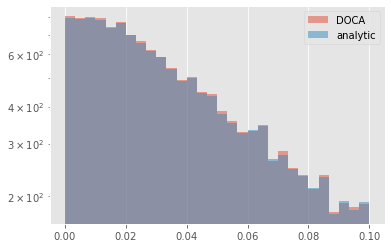

In [15]:
plt.figure()
plt.hist(df['DOCA_mu_plus'], range = (0,0.1), alpha = 0.5, bins = 'auto', label = 'DOCA')
plt.hist(df['DOCA_analytic_plus'], range = (0,0.1),alpha = 0.5, bins = 'auto', label = 'analytic')
plt.yscale('log')
plt.legend()
plt.show()

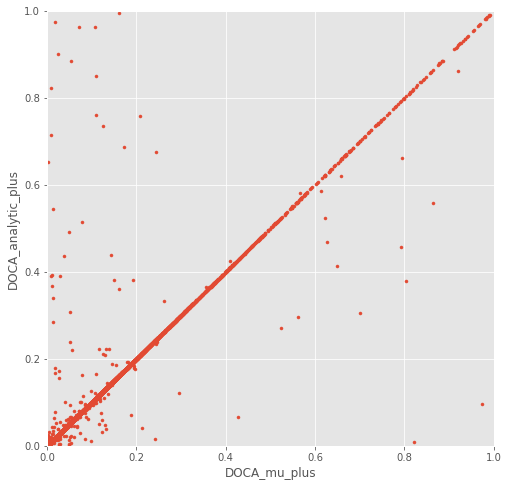

In [16]:
plt.figure(figsize=(8,8))
plt.scatter(df['DOCA_mu_plus'],  df['DOCA_analytic_plus'], marker=".")
plt.xlabel('DOCA_mu_plus')
plt.ylabel('DOCA_analytic_plus')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

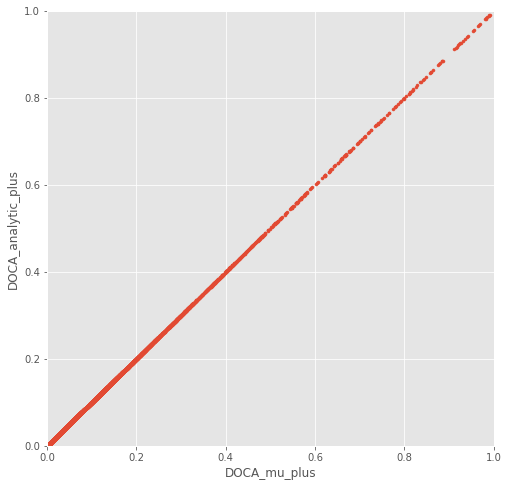

In [17]:
plt.figure(figsize=(8,8))
plt.scatter(df[(dif_plus < 0.001) & (dif_minus < 0.001) ]['DOCA_mu_plus'],  df[(dif_plus < 0.001) & (dif_minus < 0.001) ]['DOCA_analytic_plus'], marker=".")
plt.xlabel('DOCA_mu_plus')
plt.ylabel('DOCA_analytic_plus')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

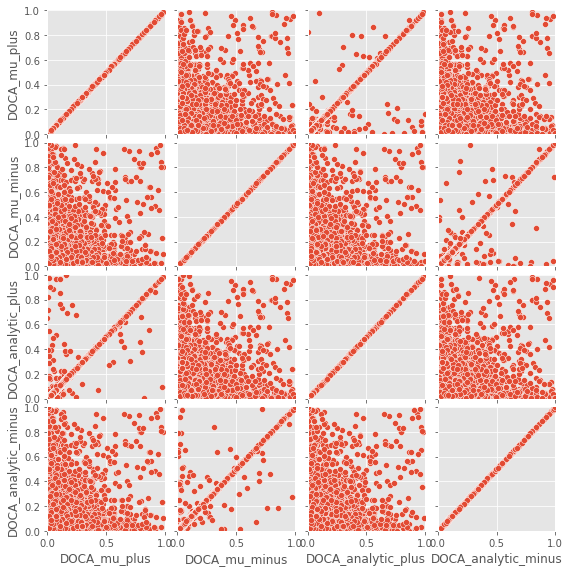

In [18]:
g = sns.pairplot(df[(df["DOCA_mu_plus"] < 1) & (df["DOCA_mu_minus"] < 1) ], vars = doca_cols, height = 2, diag_kind = None)
g.set(xlim=(0,1), ylim = (0,1))
plt.show()

In [19]:
dif_plus = abs(df["DOCA_mu_plus"] - df["DOCA_analytic_plus"])
dif_minus = abs(df["DOCA_mu_minus"] - df["DOCA_analytic_minus"])

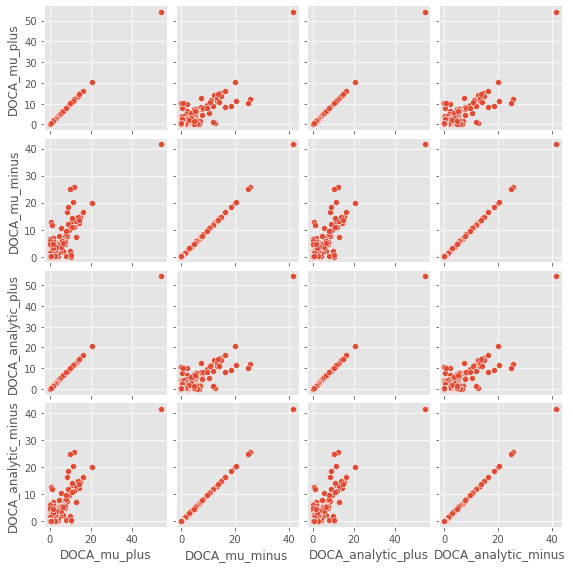

In [20]:
g = sns.pairplot(df[(dif_plus < 0.01) & (dif_minus < 0.01) ], vars = doca_cols, height = 2, diag_kind = None)
# g.set(xlim=(0,1), ylim = (0,1))
plt.show()

In [21]:
print(len(df))
print(len(df[(dif_plus < 0.001) & (dif_minus < 0.001) ]))

18032
17150


In [22]:
stats.ks_2samp(df["DOCA_mu_plus"], df["DOCA_analytic_plus"])

KstestResult(statistic=0.007264862466725863, pvalue=0.7252300030547512)

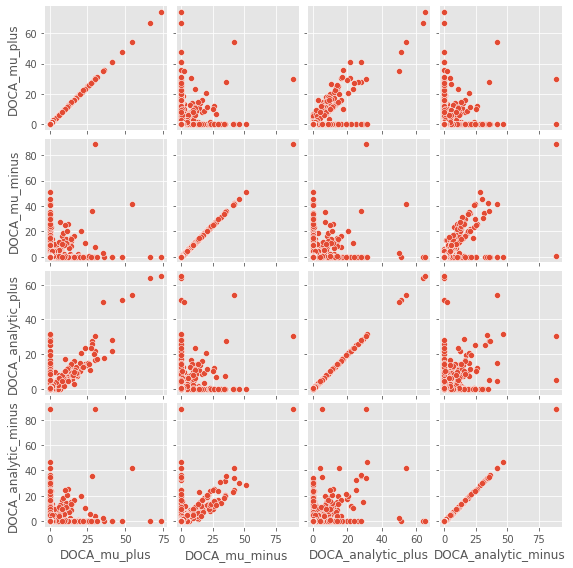

In [23]:
g = sns.pairplot(df, vars = doca_cols, height = 2, diag_kind = None)
plt.show()

In [24]:
other_cols = ['Bs_VX', 'Bs_TRUE_VX', 'phi3_TRUE_OVX', 'Bs_PX', 'Bs_TRUE_PX' ]

In [25]:
df[ (df["DOCA_mu_plus"] > 100)][doca_cols + other_cols]

,,DOCA_mu_plus,DOCA_mu_minus,DOCA_analytic_plus,DOCA_analytic_minus,Bs_VX,Bs_TRUE_VX,phi3_TRUE_OVX,Bs_PX,Bs_TRUE_PX
entry,subentry,,,,,,,,,


In [26]:
np.sum(df["DOCA_analytic_plus"] > 20) 

21

In [27]:
np.sum(np.round(df["DOCA_analytic_plus"], 1) == np.round(df["DOCA_mu_plus"], 1)) 

9764

In [28]:
df[df["DOCA_analytic_plus"] > 20][doca_cols]

,,DOCA_mu_plus,DOCA_mu_minus,DOCA_analytic_plus,DOCA_analytic_minus
entry,subentry,,,,
972,0,30.234517,0.118325,21.610840,0.118332
1818,0,0.070771,0.016479,28.856867,15.374504
2351,0,0.140732,0.076554,25.167633,32.171356
3027,0,66.414958,0.005981,64.117783,0.005982
3601,0,47.634065,0.059990,51.164093,0.060002
4253,0,0.058938,0.002456,25.021070,24.560740
7466,0,28.068712,35.809467,27.845610,35.809471
7814,0,35.343451,2.671608,50.157455,2.299408
8015,0,0.008536,0.020622,27.700222,36.246422


In [29]:
nunique = df.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
print(len(cols_to_drop))
dfdropped = df.drop(cols_to_drop, axis=1)

958


In [30]:
len(df.columns[df[(df["DOCA_mu_plus"] > 100)].isin([-9999]).any()])

0

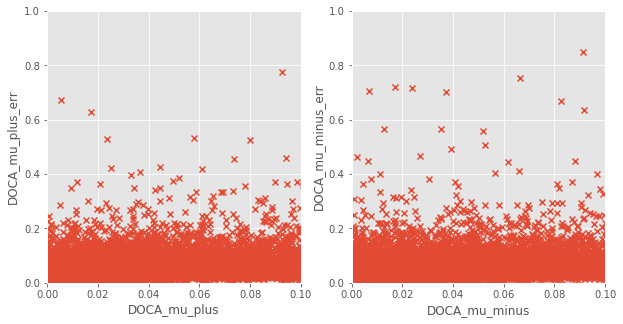

In [31]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].scatter(df['DOCA_mu_plus'], df['DOCA_mu_plus_err'], marker = 'x')
ax[0].set_xlabel('DOCA_mu_plus')
ax[0].set_ylabel('DOCA_mu_plus_err')
ax[0].set_xlim(0,0.1)
ax[0].set_ylim(0,1)
ax[1].scatter(df['DOCA_mu_minus'], df['DOCA_mu_minus_err'], marker = 'x')
ax[1].set_xlabel('DOCA_mu_minus')
ax[1].set_ylabel('DOCA_mu_minus_err')
ax[1].set_xlim(0,0.1)
ax[1].set_ylim(0,1)
plt.show()

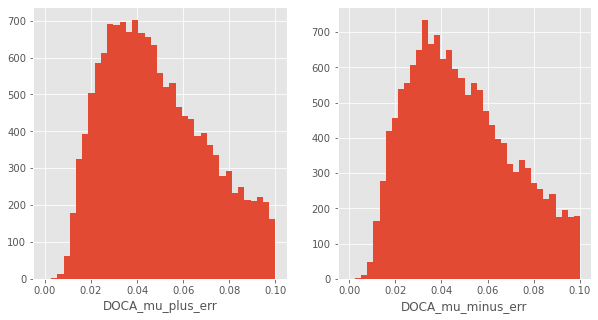

In [32]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].hist(df['DOCA_mu_plus_err'], bins = 'auto', range = (0,0.1))
ax[0].set_xlabel('DOCA_mu_plus_err')
ax[1].hist(df['DOCA_mu_minus_err'], bins = 'auto', range = (0,0.1))
ax[1].set_xlabel('DOCA_mu_minus_err')
plt.show()

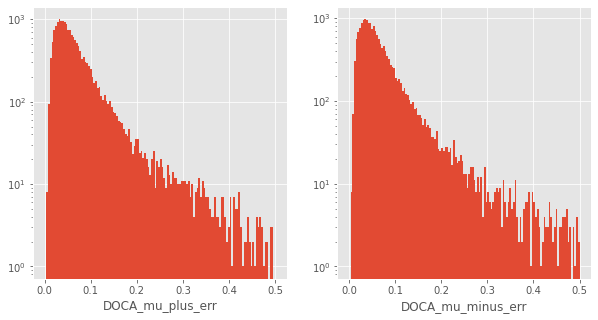

In [33]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].hist(df['DOCA_mu_plus_err'], bins = 'auto', range = (0,0.5))
ax[0].set_xlabel('DOCA_mu_plus_err')
ax[0].set_yscale('log')
ax[1].hist(df['DOCA_mu_minus_err'], bins = 'auto', range = (0,0.5))
ax[1].set_xlabel('DOCA_mu_minus_err')
ax[1].set_yscale('log')
plt.show()

In [34]:
df[['DOCA_mu_plus','DOCA_mu_plus_err','DOCA_mu_minus', 'DOCA_mu_minus_err']].describe()

,DOCA_mu_plus,DOCA_mu_plus_err,DOCA_mu_minus,DOCA_mu_minus_err
count,18032.000000,18032.000000,18032.000000,18032.000000
mean,0.243561,0.118754,0.269201,0.105508
std,1.700058,2.280020,1.875291,0.362131
min,0.000001,0.005191,0.000004,0.004174
25%,0.019126,0.034237,0.019323,0.034387
50%,0.044723,0.053359,0.045228,0.053721
75%,0.097320,0.085988,0.096131,0.085796
max,73.881259,302.105312,88.652037,18.414771


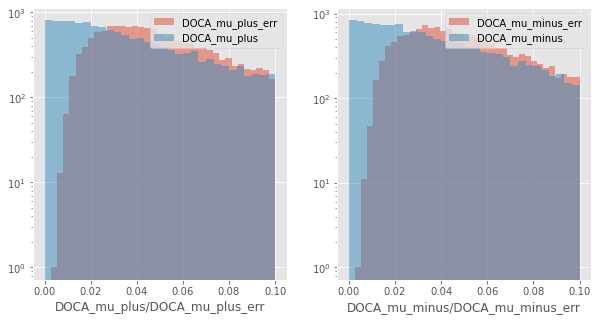

In [35]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].hist(df['DOCA_mu_plus_err'], bins = 'auto', range = (0,0.1), alpha = 0.5, label = 'DOCA_mu_plus_err')
ax[0].hist(df['DOCA_mu_plus'], bins = 'auto', range = (0,0.1), alpha = 0.5, label = 'DOCA_mu_plus')
ax[0].set_xlabel('DOCA_mu_plus/DOCA_mu_plus_err')
ax[0].set_yscale('log')
ax[0].legend()
ax[1].hist(df['DOCA_mu_minus_err'], bins = 'auto', range = (0,0.1), alpha = 0.5, label = 'DOCA_mu_minus_err')
ax[1].hist(df['DOCA_mu_minus'], bins = 'auto', range = (0,0.1), alpha = 0.5, label = 'DOCA_mu_minus')
ax[1].set_xlabel('DOCA_mu_minus/DOCA_mu_minus_err')
ax[1].set_yscale('log')
ax[1].legend()
plt.show()

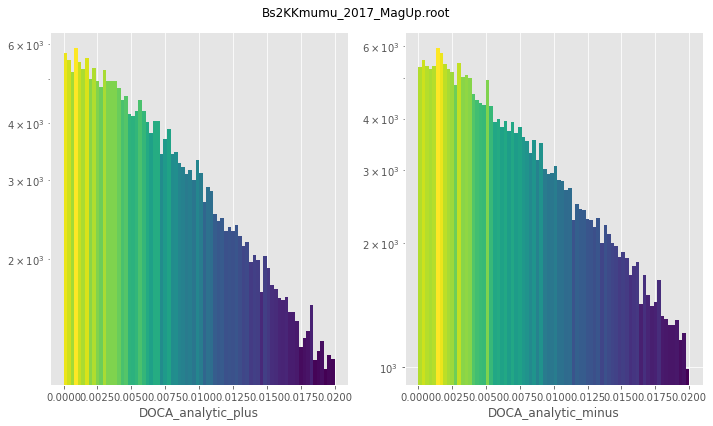

In [36]:
fig, ax = plt.subplots(nrows = 1 , ncols = 2, figsize = (10,6))
i = 0
doca_columns = ['DOCA_analytic_plus', 'DOCA_analytic_minus']
for col in ax:
    N, bins, patches = col.hist(df2[doca_columns[i]], bins = 'auto', range = (0,0.02))
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    col.set_yscale('log')
    col.set_xlabel(doca_columns[i])
    i+=1
fig.suptitle('Bs2KKmumu_2017_MagUp.root')
plt.tight_layout()
plt.show()

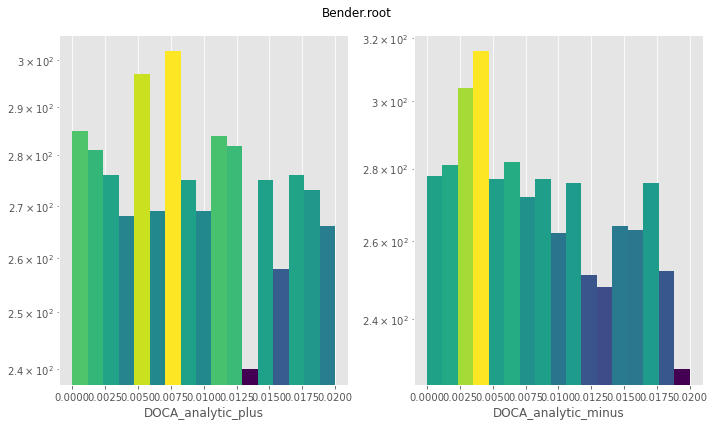

In [37]:
fig, ax = plt.subplots(nrows = 1 , ncols = 2, figsize = (10,6))
i = 0
doca_columns = ['DOCA_analytic_plus', 'DOCA_analytic_minus']
for col in ax:
    N, bins, patches = col.hist(df[doca_columns[i]], bins = 'auto', range = (0,0.02))
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    col.set_yscale('log')
    col.set_xlabel(doca_columns[i])
    i+=1
fig.suptitle('Bender.root')
plt.tight_layout()
plt.show()

In [38]:
df2[doca_columns].describe()

,DOCA_analytic_plus,DOCA_analytic_minus
count,3.252100e+05,3.252100e+05
mean,2.267519e-02,2.227973e-02
std,7.596425e-02,6.668545e-02
min,4.702617e-07,7.202035e-07
25%,4.080178e-03,4.022120e-03
50%,9.655243e-03,9.582052e-03
75%,2.116856e-02,2.086950e-02
max,1.070628e+01,1.075924e+01


In [39]:
df[doca_columns].describe()

,DOCA_analytic_plus,DOCA_analytic_minus
count,18032.000000,18032.000000
mean,0.248522,0.272987
std,1.584491,1.843615
min,0.000008,0.000005
25%,0.019254,0.019489
50%,0.045182,0.045705
75%,0.099164,0.098532
max,64.744949,88.639168


In [40]:
df2_reduced = pd.read_pickle('/home/hep/kj3417/UROP_notebooks/Bs_reduced_tau_reconstructed_data_frame_MC_phimumu.pkl.gz')

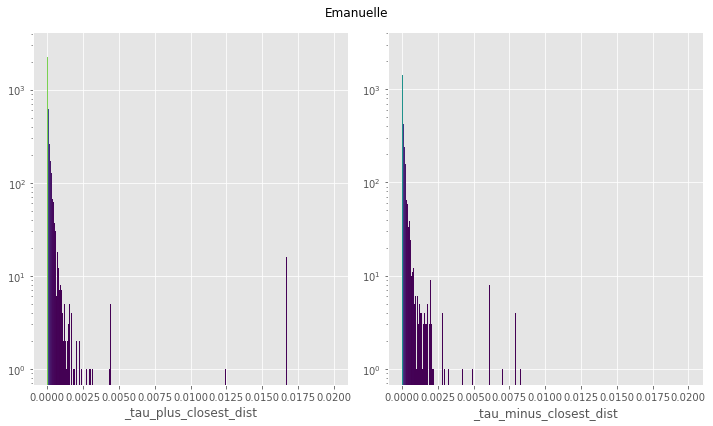

In [41]:
fig, ax = plt.subplots(nrows = 1 , ncols = 2, figsize = (10,6))
i = 0
doca_columns = ['_tau_plus_closest_dist', '_tau_minus_closest_dist']
for col in ax:
    N, bins, patches = col.hist(df2_reduced[doca_columns[i]], bins = 'auto', range = (0,0.02))
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    col.set_yscale('log')
    col.set_xlabel(doca_columns[i])
    i+=1
fig.suptitle('Emanuelle')
plt.tight_layout()
plt.show()

In [42]:
len(df2_reduced['_tau_plus_closest_dist'])

20015

In [43]:
bs_point_1 = df2_reduced[['Bs_OWNPV_X', 'Bs_OWNPV_Y', 'Bs_OWNPV_Z']].to_numpy() #on Bs LOF
bs_point_2 = df2_reduced[['Bs_ENDVERTEX_X', 'Bs_ENDVERTEX_Y', 'Bs_ENDVERTEX_Z']].to_numpy() #on Bs LOF
mu_plus_point = df2_reduced[['mu_plus_REFPX', 'mu_plus_REFPY', 'mu_plus_REFPZ']].to_numpy() #on mu + LOF
#mu_plus_point = df[['mu_plus_OWNPV_X','mu_plus_OWNPV_Y','mu_plus_OWNPV_Z']].applymap(lambda x: x[0]).to_numpy() #on mu + LOF
mu_minus_point = df2_reduced[['mu_minus_REFPX', 'mu_minus_REFPY', 'mu_minus_REFPZ']].to_numpy() #on mu - LOF
#mu_minus_point = df[['mu_minus_OWNPV_X','mu_minus_OWNPV_Y','mu_minus_OWNPV_Z']].applymap(lambda x: x[0]).to_numpy() #on mu - LOF

bs_dir = bs_point_1 - bs_point_2
mu_plus_dir = df2_reduced[['mu_plus_AtVtx_PX', 'mu_plus_AtVtx_PY', 'mu_plus_AtVtx_PZ']].to_numpy()
mu_minus_dir = df2_reduced[['mu_minus_AtVtx_PX', 'mu_minus_AtVtx_PY', 'mu_minus_AtVtx_PZ']].to_numpy()

n_plus = np.cross(bs_dir,mu_plus_dir)
n_plus = n_plus/np.linalg.norm(n_plus, axis = 1, keepdims = True)
n_minus = np.cross(bs_dir,mu_minus_dir)
n_minus = n_minus/np.linalg.norm(n_minus, axis = 1, keepdims = True)

DOCA_plus = np.abs(((mu_plus_point - bs_point_1)*n_plus).sum(1))
DOCA_minus = np.abs(((mu_minus_point - bs_point_1)*n_minus).sum(1))

df2_reduced['DOCA_analytic_plus'] = DOCA_plus
df2_reduced['DOCA_analytic_minus'] = DOCA_minus

In [44]:
print(len(df2_reduced['DOCA_analytic_plus']))
print(len(df2_reduced['_tau_plus_closest_dist']))

20015
20015


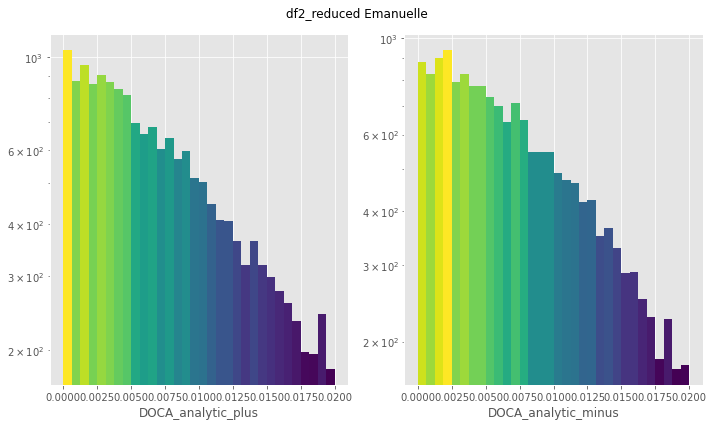

In [45]:
fig, ax = plt.subplots(nrows = 1 , ncols = 2, figsize = (10,6))
i = 0
doca_columns = ['DOCA_analytic_plus', 'DOCA_analytic_minus']
for col in ax:
    N, bins, patches = col.hist(df2_reduced[doca_columns[i]], bins = 'auto', range = (0,0.02))
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    col.set_yscale('log')
    col.set_xlabel(doca_columns[i])
    i+=1
fig.suptitle('df2_reduced Emanuelle')
plt.tight_layout()
plt.show()

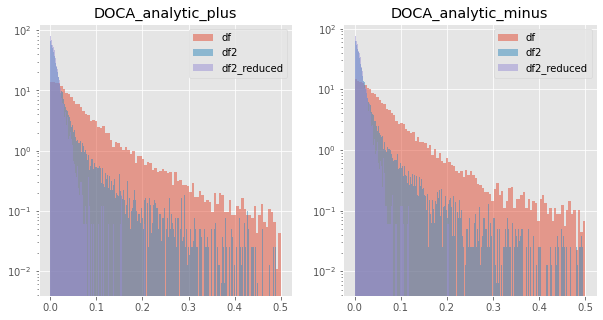

In [46]:
rge = (0, 0.5)
fig, ax = plt.subplots(1,2, figsize = (10,5))
doca_columns = ['DOCA_analytic_plus', 'DOCA_analytic_minus']
i=0
for col in ax:
    col.hist(df[doca_columns[i]], bins = 'auto', density=True, range = rge, alpha = 0.5, label = 'df')
    col.hist(df2[doca_columns[i]], bins = 'auto', density=True, range = rge, alpha = 0.5, label = 'df2')
    col.hist(df2_reduced[doca_columns[i]], bins = 'auto', density=True, range = rge, alpha = 0.5, label = 'df2_reduced')
    col.set_title(doca_columns[i])
    col.set_yscale('log')
    col.legend()
    i+=1
    
plt.show()

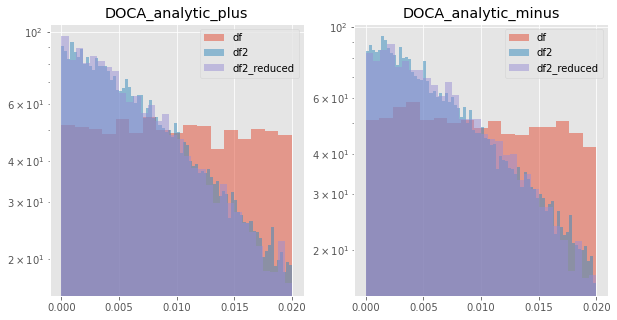

In [47]:
rge = (0, 0.02)
fig, ax = plt.subplots(1,2, figsize = (10,5))
doca_columns = ['DOCA_analytic_plus', 'DOCA_analytic_minus']
i=0
for col in ax:
    col.hist(df[doca_columns[i]], bins = 'auto', density=True, range = rge, alpha = 0.5, label = 'df')
    col.hist(df2[doca_columns[i]], bins = 'auto', density=True, range = rge, alpha = 0.5, label = 'df2')
    col.hist(df2_reduced[doca_columns[i]], bins = 'auto', density=True, range = rge, alpha = 0.5, label = 'df2_reduced')
    col.set_title(doca_columns[i])
    col.set_yscale('log')
    col.legend()
    i+=1
    
plt.show()

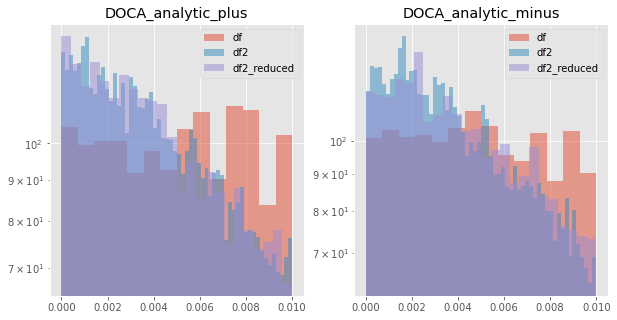

In [48]:
rge = (0, 0.01)
fig, ax = plt.subplots(1,2, figsize = (10,5))
doca_columns = ['DOCA_analytic_plus', 'DOCA_analytic_minus']
i=0
for col in ax:
    col.hist(df[doca_columns[i]], bins = 'auto', density=True, range = rge, alpha = 0.5, label = 'df')
    col.hist(df2[doca_columns[i]], bins = 'auto', density=True, range = rge, alpha = 0.5, label = 'df2')
    col.hist(df2_reduced[doca_columns[i]], bins = 'auto', density=True, range = rge, alpha = 0.5, label = 'df2_reduced')
    col.set_title(doca_columns[i])
    col.set_yscale('log')
    col.legend()
    i+=1
    
plt.show()

In [49]:
tau_start = df[['phi3_VX', 'phi3_VY', 'phi3_VZ']].to_numpy()
tauplus_end = df[tauplus_closest_vars].to_numpy() # THE CLOSEST DISTANCE POINT
tauminus_end = df[tauminus_closest_vars].to_numpy() # THE CLOSEST DISTANCE POINT

# tauplus_end = df[['tauplus_VX', 'tauplus_VY', 'tauplus_VZ']].to_numpy() # THE CLOSEST DISTANCE POINT
# tauminus_end = df[['tauminus_VX', 'tauminus_VY', 'tauminus_VZ']].to_numpy() # THE CLOSEST DISTANCE POINT

bs_dir = df[['phi3_PX', 'phi3_PY','phi3_PZ']].to_numpy()

diff_plus = tauplus_end - tau_start
diff_minus = tauminus_end - tau_start

sign_plus =  +1 # inner1d(bs_dir,diff_plus)/abs(inner1d(bs_dir,diff_plus))
sign_minus =  +1 # inner1d(bs_dir,diff_minus)/abs(inner1d(bs_dir,diff_minus))

mag_plus = np.sum(np.abs(diff_plus)**2,axis=-1)**(1./2)
mag_minus = np.sum(np.abs(diff_minus)**2,axis=-1)**(1./2)

df['tauplus_analytic_FD'] = mag_plus * sign_plus # added the sign!!! Important if want to knwo which way the tau went basically
df['tauminus_analytic_FD'] = mag_minus * sign_minus # added the sign!!! Important if want to knwo which way the tau went basically
        

In [50]:
df[['phi3_TRUE_OVX','phi3_VX', 'Bs_TRUE_VX', 'Bs_VX', 'tauplus_TRUE_OVX', 'tauminus_TRUE_OVX', 'muplus_RefPoint_X', 'tauplus_VX', tauplus_closest_vars[0], 'Bs_MINIPCHI2']]

,,phi3_TRUE_OVX,phi3_VX,Bs_TRUE_VX,Bs_VX,tauplus_TRUE_OVX,tauminus_TRUE_OVX,muplus_RefPoint_X,tauplus_VX,tauplus_closest_x,Bs_MINIPCHI2
entry,subentry,,,,,,,,,,
0,0,0.1504,0.859455,0.1504,-0.272051,0.1504,0.1504,0.0262,0.0262,-0.351765,32.030376
1,0,-0.0135,-0.242190,-0.0135,-0.206118,-0.0135,-0.0135,0.0646,0.0646,1.641302,50.017212
2,0,-0.5663,2.797000,-0.5663,-0.596074,-0.5663,-0.5663,-0.0211,-0.0211,0.359763,41.553547
3,0,0.5147,0.564435,0.5147,0.406787,0.5147,0.5147,0.0561,0.0561,0.322588,38.697811
4,0,0.8402,0.856744,0.8402,0.878515,0.8402,0.8402,0.0625,0.0625,0.780122,3.160773
...,...,...,...,...,...,...,...,...,...,...,...
18161,0,1.2456,0.829001,1.2456,1.236536,1.2456,1.2456,1.1770,1.1770,1.224622,18.688398
18162,0,1.0852,1.359831,1.0852,1.162450,1.0852,1.0852,0.9978,0.9978,0.996242,48.097450
18163,0,1.6012,1.583231,1.6012,1.603006,1.6012,1.6012,0.2920,0.2920,1.525161,116.529930


In [51]:
df[tauplus_closest_vars[0]]

entry  subentry
0      0          -0.351765
1      0           1.641302
2      0           0.359763
3      0           0.322588
4      0           0.780122
                     ...   
18161  0           1.224622
18162  0           0.996242
18163  0           1.525161
18164  0           0.988337
18165  0           1.113065
Name: tauplus_closest_x, Length: 18032, dtype: float64

In [53]:
fd_cols = ['FD_tau_plus', 'FD_tau_minus', 'tauplus_analytic_FD','tauminus_analytic_FD']
df[fd_cols].describe()

,FD_tau_plus,FD_tau_minus,tauplus_analytic_FD,tauminus_analytic_FD
count,18032.000000,18032.000000,18032.000000,18032.000000
mean,15.597236,10.116417,17.249240,17.846204
std,753.176247,112.936122,141.555703,165.208973
min,0.000444,0.000295,0.000120,0.000228
25%,0.264863,0.257252,0.795893,0.773215
50%,0.978385,0.981113,2.079835,2.047047
75%,3.162536,3.178744,5.340717,5.414183
max,100065.443340,8963.625229,8846.156054,11328.890950


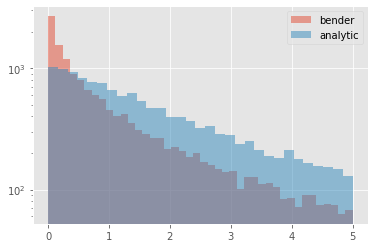

In [55]:
plt.figure()
df['FD_tau_plus'].hist(bins = 'auto', range = (0, 5), alpha=0.5, label="bender")
df['tauplus_analytic_FD'].hist(bins = 'auto', range = (0, 5), alpha=0.5, label="analytic")
plt.yscale('log')
plt.legend()
plt.show()

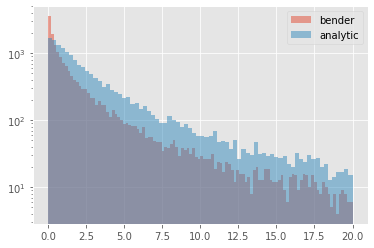

In [56]:
plt.figure()
df['FD_tau_plus'].hist(bins = 'auto', range = (0, 20), alpha=0.5, label="bender")
df['tauplus_analytic_FD'].hist(bins = 'auto', range = (0, 20), alpha=0.5, label="analytic")
plt.yscale('log')
plt.legend()
plt.show()

In [57]:
len(df[df['phi3_PX']==-9999])

0

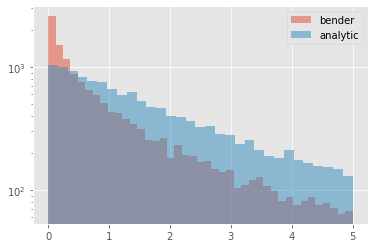

In [88]:
plt.figure()
df[ (dif_plus < 0.001) & (dif_minus < 0.001)]['FD_tau_plus'].hist(bins = 'auto', range = (0, 5), alpha=0.5, label="bender")
df['tauplus_analytic_FD'].hist(bins = 'auto', range = (0, 5), alpha=0.5, label="analytic")
plt.yscale('log')
plt.legend()
plt.show()

In [90]:
len(df[ (dif_plus < 0.001) & (dif_minus < 0.001) &  (df['FD_tau_plus'] != -9999) ])

17150

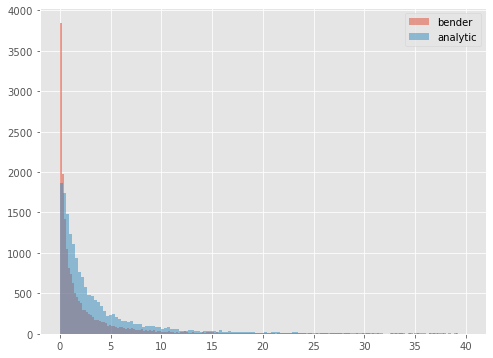

In [92]:
plt.figure(figsize=(8,6))
df[df['FD_tau_minus'] != -9999]['FD_tau_minus'].hist(bins = 'auto', range = (0, 40), alpha=0.5, label="bender")
df['tauminus_analytic_FD'].hist(bins = 'auto', range = (0, 40), alpha=0.5, label="analytic")
# plt.yscale('log')
plt.legend()
plt.show()

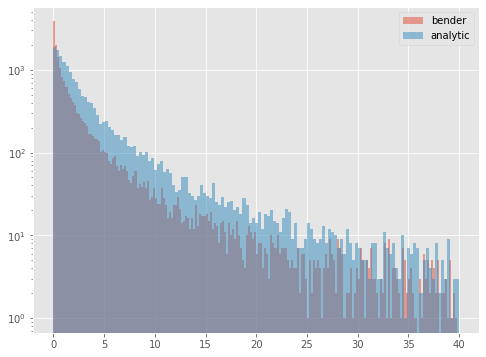

In [93]:
plt.figure(figsize=(8,6))
df[df['FD_tau_minus'] != -9999]['FD_tau_minus'].hist(bins = 'auto', range = (0, 40), alpha=0.5, label="bender")
df['tauminus_analytic_FD'].hist(bins = 'auto', range = (0, 40), alpha=0.5, label="analytic")
plt.yscale('log')
plt.legend()
plt.show()

In [94]:
"""
plt.figure()
df[(df['FD_tau_minus'] != -9999) & (df['FD_tau_minus'] < 3000)]['FD_tau_minus'].hist(bins = 'auto', alpha=0.5, label="bender")
df[(df['FD_tau_minus'] < 3000)]['tauminus_analytic_FD'].hist(bins = 'auto', alpha=0.5, label="analytic")
plt.yscale('log')
plt.legend()
plt.show()
"""

'\nplt.figure()\ndf[(df[\'FD_tau_minus\'] != -9999) & (df[\'FD_tau_minus\'] < 3000)][\'FD_tau_minus\'].hist(bins = \'auto\', alpha=0.5, label="bender")\ndf[(df[\'FD_tau_minus\'] < 3000)][\'tauminus_analytic_FD\'].hist(bins = \'auto\', alpha=0.5, label="analytic")\nplt.yscale(\'log\')\nplt.legend()\nplt.show()\n'

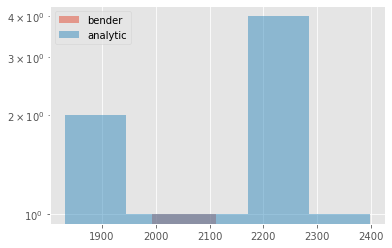

In [95]:
plt.figure()
df[(df['FD_tau_minus'] != -9999) & (1800 < df['FD_tau_minus']) & (df['FD_tau_minus'] < 2500)]['FD_tau_minus'].hist(bins = 'auto', alpha=0.5, label="bender")
df[(1800 < df['tauminus_analytic_FD']) & (df['tauminus_analytic_FD'] < 2500)]['tauminus_analytic_FD'].hist(bins = 'auto', alpha=0.5, label="analytic")
plt.yscale('log')
plt.legend()
plt.show()

In [96]:
print(len(df['IP_mu_plus']))
print(len(df[df['IP_mu_plus'] != -9999]))

18032
18032


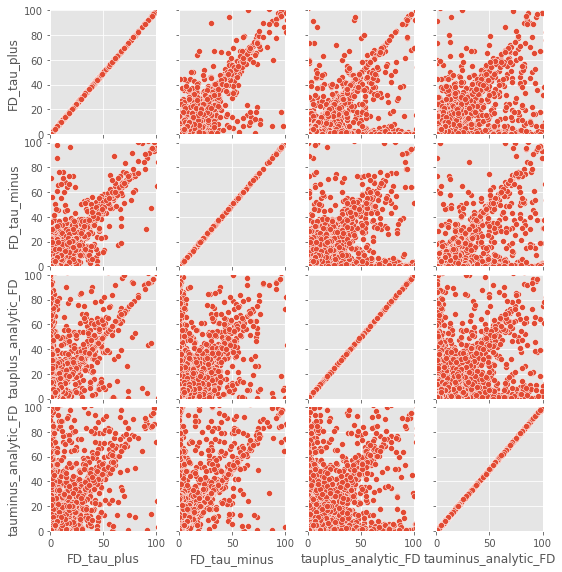

In [97]:
fd_cols = ['FD_tau_plus', 'FD_tau_minus', 'tauplus_analytic_FD','tauminus_analytic_FD']

g = sns.pairplot(df, vars = fd_cols, height = 2, diag_kind = None)
g.set(xlim=(0,100), ylim = (0,100))
plt.show()

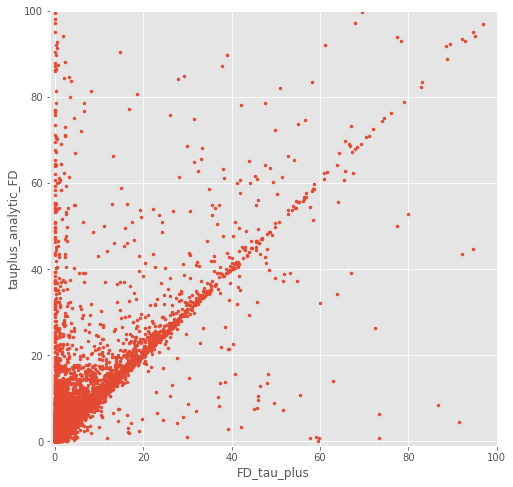

In [98]:
plt.figure(figsize=(8,8))
plt.scatter(df[df['FD_tau_plus']!=-9999]['FD_tau_plus'],  df[df['FD_tau_plus']!=-9999]['tauplus_analytic_FD'], marker=".")
plt.xlabel('FD_tau_plus')
plt.ylabel('tauplus_analytic_FD')
plt.xlim(-1, 100)
plt.ylim(-1, 100)
plt.show()

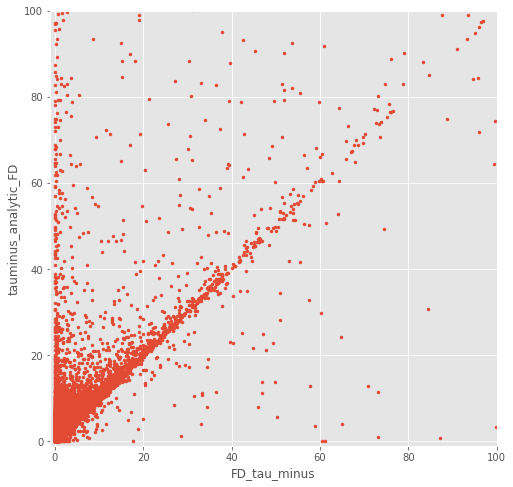

In [99]:
plt.figure(figsize=(8,8))
plt.scatter(df['FD_tau_minus'],  df['tauminus_analytic_FD'], marker=".")
plt.xlabel('FD_tau_minus')
plt.ylabel('tauminus_analytic_FD')
plt.xlim(-1, 100)
plt.ylim(-1, 100)
plt.show()

In [100]:
bs_point = df[['phi3_VX','phi3_VY','phi3_VZ']].to_numpy() #on Bs LOF
mu_plus_point = df[['muplus_RefPoint_X','muplus_RefPoint_Y','muplus_RefPoint_Z']].to_numpy() #on mu + LOF
mu_minus_point = df[['muminus_RefPoint_X','muminus_RefPoint_Y','muminus_RefPoint_Z']].to_numpy() #on mu - LOF

mu_plus_dir = df[['muplus_PX','muplus_PY','muplus_PZ']].to_numpy()
mu_minus_dir = df[['muminus_PX','muminus_PY','muminus_PZ']].to_numpy()

n_mu_plus = mu_plus_dir/np.linalg.norm(mu_plus_dir, axis = 1, keepdims = True)
n_mu_minus = mu_minus_dir/np.linalg.norm(mu_minus_dir, axis = 1, keepdims = True)

d_along_mu_plus = np.abs(((mu_plus_point - bs_point)*n_mu_plus).sum(1))
d_along_mu_minus = np.abs(((mu_minus_point - bs_point)*n_mu_minus).sum(1))

diff_plus = np.linalg.norm( (mu_plus_point - bs_point) , axis = 1)
diff_minus = np.linalg.norm( (mu_minus_point - bs_point) , axis = 1)

IP_plus = np.sqrt(np.abs(diff_plus**2 - d_along_mu_plus**2))
IP_minus = np.sqrt(np.abs(diff_minus**2 - d_along_mu_minus**2))

df['IP_analytic_plus'] = IP_plus
df['IP_analytic_minus'] = IP_minus


In [101]:
d_along_mu_plus

array([ 46.403458 ,  12.283162 , 102.5467   , ...,  35.028458 ,
         1.1106547,  10.2909565], dtype=float32)

In [102]:
diff_plus 

array([ 46.430706 ,  12.283429 , 102.54893  , ...,  35.028477 ,
         1.1136243,  10.318296 ], dtype=float32)

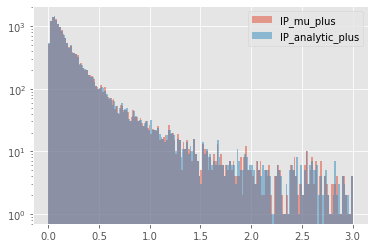

In [103]:
plt.figure()
df[df['IP_mu_plus'] != -9999]['IP_mu_plus'].hist(bins = 'auto', range=(0, 3), alpha=0.5, label='IP_mu_plus')
df[df['IP_analytic_plus'] != -9999]['IP_analytic_plus'].hist(bins = 'auto', range=(0, 3), alpha=0.5, label='IP_analytic_plus')
plt.yscale('log')
plt.legend()
plt.show()

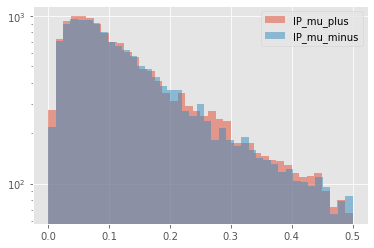

In [104]:
plt.figure()
df[df['IP_mu_plus'] != -9999]['IP_mu_plus'].hist(bins = 'auto', range=(0, 0.5), alpha=0.5, label='IP_mu_plus')
df[df['IP_mu_minus'] != -9999]['IP_mu_minus'].hist(bins = 'auto', range=(0, 0.5), alpha=0.5, label='IP_mu_minus')
plt.legend()
plt.yscale('log')
plt.show()

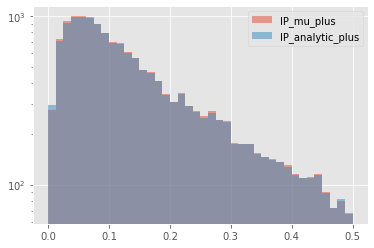

In [105]:
plt.figure()
df[df['IP_mu_plus'] != -9999]['IP_mu_plus'].hist(bins = 'auto', range=(0, 0.5), alpha=0.5, label='IP_mu_plus')
df[df['IP_analytic_plus'] != -9999]['IP_analytic_plus'].hist(bins = 'auto', range=(0, 0.5), alpha=0.5, label='IP_analytic_plus')
plt.yscale('log')
plt.legend()
plt.show()

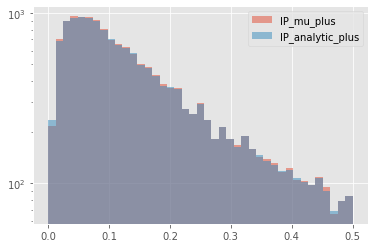

In [106]:
plt.figure()
df[df['IP_mu_minus'] != -9999]['IP_mu_minus'].hist(bins = 'auto', range=(0, 0.5), alpha=0.5, label='IP_mu_plus')
df[df['IP_analytic_minus'] != -9999]['IP_analytic_minus'].hist(bins = 'auto', range=(0, 0.5), alpha=0.5, label='IP_analytic_plus')
plt.yscale('log')
plt.legend()
plt.show()

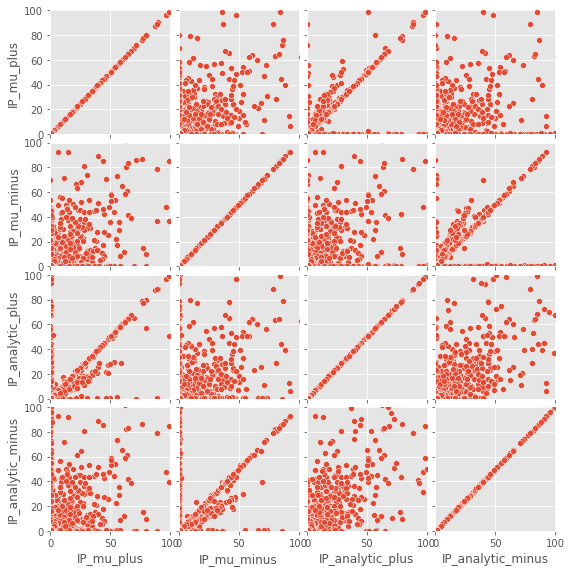

In [107]:
ip_cols = ['IP_mu_plus', 'IP_mu_minus', 'IP_analytic_plus','IP_analytic_minus']

g = sns.pairplot(df, vars = ip_cols, height = 2, diag_kind = None)
g.set(xlim=(0,100), ylim = (0,100))
plt.show()

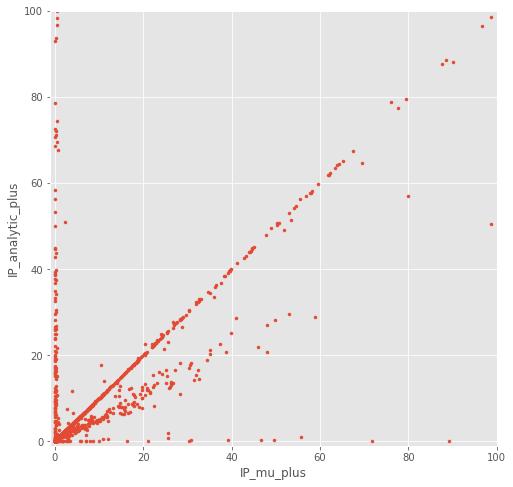

In [108]:
plt.figure(figsize=(8,8))
plt.scatter(df[df['IP_mu_plus'] != -9999]['IP_mu_plus'],  df['IP_analytic_plus'], marker=".")
plt.xlabel('IP_mu_plus')
plt.ylabel('IP_analytic_plus')
plt.xlim(-1, 100)
plt.ylim(-1, 100)
plt.show()

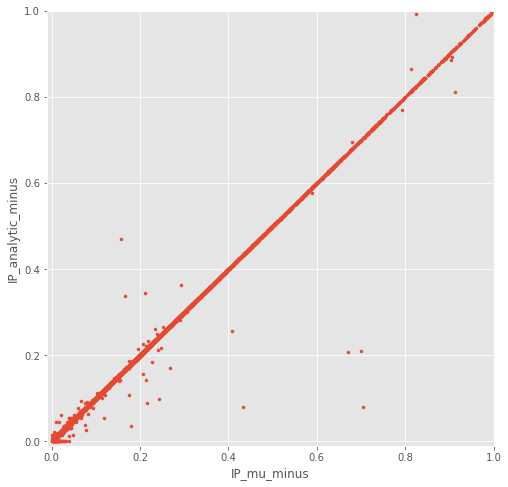

In [109]:
plt.figure(figsize=(8,8))
plt.scatter(df[df['DOCA_analytic_plus'] < 0.05 ]['IP_mu_minus'],  df[df['DOCA_analytic_plus'] < 0.05 ]['IP_analytic_minus'], marker=".")
plt.xlabel('IP_mu_minus')
plt.ylabel('IP_analytic_minus')
plt.xlim(-0.01, 1)
plt.ylim(-0.01, 1)
plt.show()

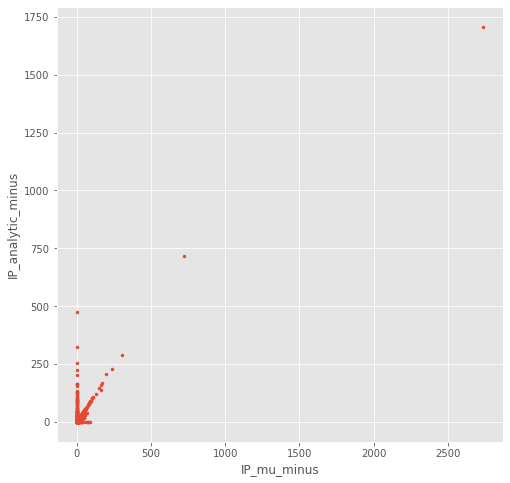

In [110]:
plt.figure(figsize=(8,8))
plt.scatter(df['IP_mu_minus'],  df['IP_analytic_minus'], marker=".")
plt.xlabel('IP_mu_minus')
plt.ylabel('IP_analytic_minus')
plt.show()

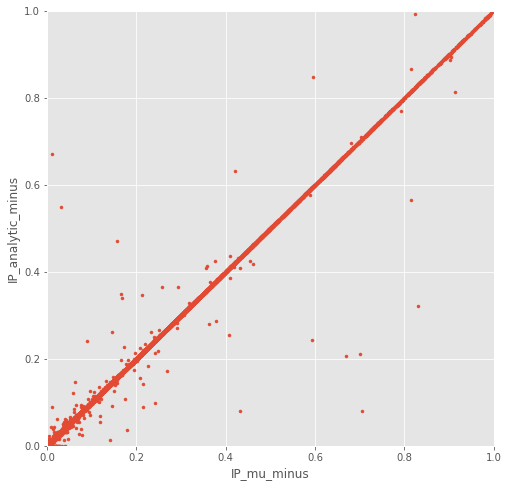

In [111]:
plt.figure(figsize=(8,8))
plt.scatter(df['IP_mu_minus'],  df['IP_analytic_minus'], marker=".")
plt.xlabel('IP_mu_minus')
plt.ylabel('IP_analytic_minus')
plt.xlim(0, 1)
plt.ylim(0,1)
plt.show()

In [112]:
df[df['IP_mu_minus'] < 0.001 ]

,,Bs_TRUE_M,Bs_TRUE_PX,Bs_TRUE_PY,Bs_TRUE_PZ,Bs_TRUE_E,Bs_TRUE_P,Bs_TRUE_PT,Bs_TRUE_ETA,Bs_TRUE_PHI,Bs_TRUE_VX,...,muplus_closest_z,muminus_closest_x,muminus_closest_y,muminus_closest_z,DOCA_mu_plus_err,DOCA_mu_minus_err,tauplus_analytic_FD,tauminus_analytic_FD,IP_analytic_plus,IP_analytic_minus
entry,subentry,,,,,,,,,,,,,,,,,,,,,
7268,0,5366.769978,7421.03,-5997.86,162632.81,163000.856192,162912.482331,9541.803333,3.529819,-0.679736,1.9769,...,58.389854,2.043504,-0.819884,58.686569,0.029431,0.037021,0.304986,0.006099,0.040782,0.015625


In [113]:
IPall = [i for i in list(df.columns.values) if "IP_" in i]
df[IPall].describe()

,IP_mu_plus,IP_chi2_mu_plus,IP_mu_minus,IP_chi2_mu_minus,IP_analytic_plus,IP_analytic_minus
count,18032.000000,18032.000000,18032.000000,18032.000000,18032.000000,18032.000000
mean,1.084816,14.847181,1.179367,15.264509,1.371312,1.392401
std,13.599285,122.709466,21.987353,158.909496,14.059593,16.593330
min,0.000292,0.000004,0.000349,0.000042,0.000000,0.000000
25%,0.069645,0.955103,0.071042,0.964494,0.069877,0.071443
50%,0.147004,2.667575,0.147962,2.659513,0.148282,0.149214
75%,0.329737,7.268938,0.332421,7.413130,0.337660,0.340105
max,1407.724884,10485.508028,2735.900266,15654.203650,1169.273315,1707.245728


In [114]:
dif_ip_plus = abs(df["IP_mu_plus"] - df["IP_analytic_plus"])
dif_ip_minus = abs(df["IP_mu_minus"] - df["IP_analytic_minus"])

print(len(df))
print(len(df[(dif_ip_plus < 0.001) & (dif_ip_minus < 0.001) ]))

18032
15849


In [115]:
dif_fd_plus = abs(df["FD_tau_plus"] - df["tauplus_analytic_FD"])
dif_fd_minus = abs(df["FD_tau_minus"] - df["tauminus_analytic_FD"])

print(len(df))
print(len(df[(dif_fd_plus < 1) & (dif_fd_minus < 1) ]))

18032
9189


In [116]:
vfitall = [i for i in list(df.columns.values) if "VFIT_" in i]
df[vfitall].describe()

,VFIT_plus_x,VFIT_plus_y,VFIT_plus_z,VFIT_minus_x,VFIT_minus_y,VFIT_minus_z
count,18032.000000,18032.000000,18032.000000,18032.000000,18032.000000,18032.000000
mean,0.853100,0.130098,8.137186,0.859102,0.123288,13.754882
std,1.773143,1.252633,746.585085,2.243478,1.044980,48.933871
min,-154.899607,-38.773536,-100000.000000,-156.382337,-40.715791,-458.288603
25%,0.622228,-0.100498,-10.269512,0.626236,-0.100368,-10.361752
50%,0.838018,0.107717,11.910756,0.838238,0.106420,12.063884
75%,1.045960,0.336134,37.048460,1.050267,0.332204,37.232921
max,137.563742,67.681690,3848.165943,229.457279,46.581896,3067.934185


In [117]:
vfitall2 = ['VFIT_plus_x','VFIT_minus_x', 'tauplus_VX', 'muplus_RefPoint_X', 'phi3_VX']
df[vfitall2].describe()

,VFIT_plus_x,VFIT_minus_x,tauplus_VX,muplus_RefPoint_X,phi3_VX
count,18032.000000,18032.000000,18032.000000,18032.000000,18032.000000
mean,0.853100,0.859102,-0.459263,-0.459263,0.754542
std,1.773143,2.243478,27.168789,27.168789,10.299233
min,-154.899607,-156.382337,-681.557922,-681.557922,-811.965149
25%,0.622228,0.626236,0.102400,0.102400,0.608433
50%,0.838018,0.838238,0.398150,0.398150,0.835651
75%,1.045960,1.050267,0.709200,0.709200,1.059713
max,137.563742,229.457279,544.654602,544.654602,369.127869


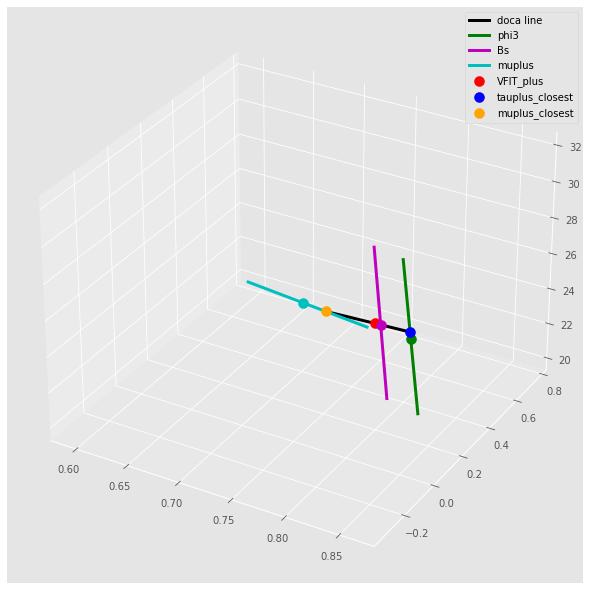

In [118]:
# %matplotlib notebook
n = 194
#n = 135
# n = 175
# n = 178
# n = 1944
#n = 132

xrange = df['muplus_RefPoint_X'][n][0] - df['tauplus_closest_x'][n][0]

t = np.linspace(-5, 5, 10)

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)

ax.scatter(df['VFIT_plus_x'][n], df['VFIT_plus_y'][n], df['VFIT_plus_z'][n], s=100, color="r", label = 'VFIT_plus')
ax.scatter(df['tauplus_closest_x'][n], df['tauplus_closest_y'][n], df['tauplus_closest_z'][n], s=100, color="b", label = 'tauplus_closest')
ax.scatter(df['muplus_closest_x'][n], df['muplus_closest_y'][n], df['muplus_closest_z'][n], s=100, color="orange", label = 'muplus_closest')
ax.scatter(df['phi3_VX'][n], df['phi3_VY'][n], df['phi3_VZ'][n], s=100, color="g")
ax.scatter(df['muplus_RefPoint_X'][n], df['muplus_RefPoint_Y'][n], df['muplus_RefPoint_Z'][n], s=100, color="c")
ax.scatter(df['Bs_VX'][n], df['Bs_VY'][n], df['Bs_VZ'][n], s=100, color="m")

ax.plot([df['muplus_closest_x'][n][0], df['tauplus_closest_x'][n][0]],
        [df['muplus_closest_y'][n][0], df['tauplus_closest_y'][n][0]],
        [df['muplus_closest_z'][n][0], df['tauplus_closest_z'][n][0]], lw=3, color="black", label="doca line")

ax.plot(df['phi3_VX'][n][0] + t*df['phi3_PX'][n][0]/df['phi3_P'][n][0],
        df['phi3_VY'][n][0] + t*df['phi3_PY'][n][0]/df['phi3_P'][n][0], 
        df['phi3_VZ'][n][0] + t*df['phi3_PZ'][n][0]/df['phi3_P'][n][0], lw=3, color='g', label='phi3')


ax.plot(df['Bs_VX'][n][0] + t*df['Bs_PX'][n][0]/df['Bs_P'][n][0],
        df['Bs_VY'][n][0] + t*df['Bs_PY'][n][0]/df['Bs_P'][n][0], 
        df['Bs_VZ'][n][0] + t*df['Bs_PZ'][n][0]/df['Bs_P'][n][0], lw=3, color='m', label='Bs')


ax.plot(df['muplus_RefPoint_X'][n][0] + t*df['muplus_PX'][n][0]/df['muplus_P'][n][0],
        df['muplus_RefPoint_Y'][n][0] + t*df['muplus_PY'][n][0]/df['muplus_P'][n][0], 
        df['muplus_RefPoint_Z'][n][0] + t*df['muplus_PZ'][n][0]/df['muplus_P'][n][0], lw=3, color='c', label='muplus')


# ax.set_zlim(df['VFIT_plus_z'][n][0] - xrange, df['VFIT_plus_z'][n][0] + xrange)
plt.legend()
plt.show()

In [119]:
[df['muplus_closest_x'][n][0], df['muplus_closest_y'][n][0], df['muplus_closest_z'][n][0]]

[0.7779529094696045, 0.015473589301109314, 26.954431533813477]

In [120]:
%matplotlib inline

In [121]:
n = 14
analytic_muplus_point = df[['muplus_closest_x', 'muplus_closest_y', 'muplus_closest_z']].to_numpy()[n]
analytic_tauplus_point = df[['tauplus_closest_x', 'tauplus_closest_y', 'tauplus_closest_z']].to_numpy()[n]

doca_plus_frompoints = np.sqrt(np.sum((analytic_tauplus_point-analytic_muplus_point)**2, axis=0))

print("doca from points", doca_plus_frompoints)
print("doca from bender", df['DOCA_mu_plus'][n][0])

doca from points 0.027640686227199975
doca from bender 0.027640798916756592


In [122]:
df['phi3_P'][n]

subentry
0    178504.640625
Name: phi3_P, dtype: float32

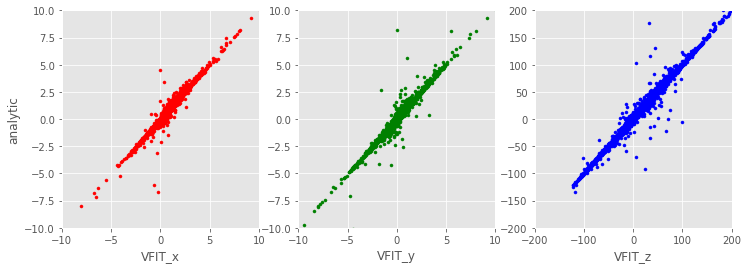

In [123]:

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].scatter(df[df['DOCA_analytic_plus'] < 0.05 ]['VFIT_plus_x'],  df[df['DOCA_analytic_plus'] < 0.05 ]['tauplus_closest_x'], marker=".", color="r")
ax[0].set_xlim(-10, 10)
ax[0].set_ylim(-10, 10)
ax[0].set_ylabel("analytic")
ax[0].set_xlabel("VFIT_x")
ax[1].scatter(df[df['DOCA_analytic_plus'] < 0.05 ]['VFIT_plus_y'],  df[df['DOCA_analytic_plus'] < 0.05 ]['tauplus_closest_y'], marker=".", color="g")
ax[1].set_xlim(-10, 10)
ax[1].set_ylim(-10, 10)
ax[1].set_xlabel("VFIT_y")
ax[2].scatter(df[df['DOCA_analytic_plus'] < 0.05 ]['VFIT_plus_z'],  df[df['DOCA_analytic_plus'] < 0.05 ]['tauplus_closest_z'], marker=".", color="b")
ax[2].set_xlim(-200, 200)
ax[2].set_ylim(-200, 200)
ax[2].set_xlabel("VFIT_z")
# plt.ylim(-1, 50)
# plt.xlabel('VFIT')
# plt.ylabel('emanuelle')
plt.show()

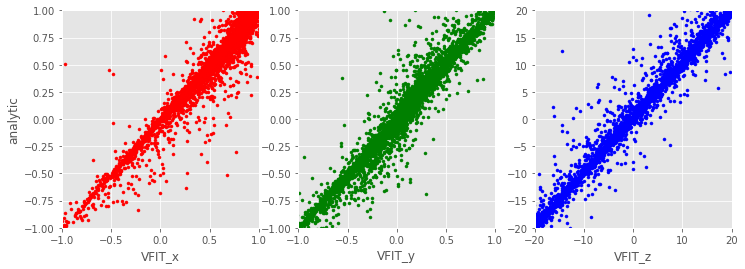

In [124]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].scatter(df[df['DOCA_analytic_plus'] < 0.05 ]['VFIT_plus_x'],  df[df['DOCA_analytic_plus'] < 0.05 ]['tauplus_closest_x'], marker=".", color="r")
ax[0].set_xlim(-1, 1)
ax[0].set_ylim(-1, 1)
ax[0].set_ylabel("analytic")
ax[0].set_xlabel("VFIT_x")
ax[1].scatter(df[df['DOCA_analytic_plus'] < 0.05 ]['VFIT_plus_y'],  df[df['DOCA_analytic_plus'] < 0.05 ]['tauplus_closest_y'], marker=".", color="g")
ax[1].set_xlim(-1, 1)
ax[1].set_ylim(-1, 1)
ax[1].set_xlabel("VFIT_y")
ax[2].scatter(df[df['DOCA_analytic_plus'] < 0.05 ]['VFIT_plus_z'],  df[df['DOCA_analytic_plus'] < 0.05 ]['tauplus_closest_z'], marker=".", color="b")
ax[2].set_xlim(-20, 20)
ax[2].set_ylim(-20, 20)
ax[2].set_xlabel("VFIT_z")
# plt.ylim(-1, 50)
# plt.xlabel('VFIT')
# plt.ylabel('emanuelle')
plt.show()

In [125]:
len(df[df['DOCA_analytic_plus'] < 0.05 ])

9638

In [126]:
vfit_plus_point = df[['VFIT_plus_x', 'VFIT_plus_y', 'VFIT_plus_z']].to_numpy()
analytic_plus_point = df[['tauplus_closest_x', 'tauplus_closest_y', 'tauplus_closest_z']].to_numpy()

# vfit_minus_point = df[['VFIT_minus_x', 'VFIT_minus_y', 'VFIT_minus_z']].to_numpy()
# analytic_minus_point = df[['tauminus_closest_x', 'tauminus_closest_y', 'tauminus_closest_z']].to_numpy()

diff_plus = np.linalg.norm( (vfit_plus_point - analytic_plus_point) , axis = 1)
# diff_minus = np.linalg.norm( (vfit_minus_point - analytic_minus_point) , axis = 1)


In [127]:
analytic_muplus_point = df[['muplus_closest_x', 'muplus_closest_y', 'muplus_closest_z']].to_numpy()[n]
analytic_tauplus_point = df[['tauplus_closest_x', 'tauplus_closest_y', 'tauplus_closest_z']].to_numpy()[n]

doca_plus_frompoints = np.sqrt(np.sum((analytic_tauplus_point-analytic_muplus_point)**2, axis=0))

print("doca_plus_frompoints", doca_plus_frompoints)
print(df['DOCA_mu_plus'][n])

doca_plus_frompoints 0.027640686227199975
subentry
0    0.027641
Name: DOCA_mu_plus, dtype: float64


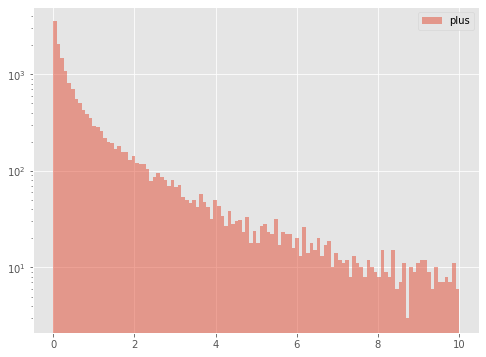

In [128]:
plt.figure(figsize=(8,6))
plt.hist(diff_plus, bins='auto', range=(0, 10), alpha=0.5, label="plus")
# plt.hist(diff_minus, bins = 'auto', alpha=0.5, label="plus")
plt.yscale('log')
plt.legend()
plt.show()